# Load Packages

In [3]:
from io import BytesIO
from office365.runtime.auth.authentication_context import AuthenticationContext
from office365.sharepoint.client_context import ClientContext
import pandas as pd

from influxdb import InfluxDBClient
from functools import reduce

import dcor
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
import itertools
import numpy as np

from matplotlib import patches

pd.set_option('display.max_columns', 200)

# Metadata

In [4]:
# # Constants for the SharePoint connection
# TENANT_ID = "c9dc265f-a55d-466a-920c-9eb2e81f750f"
# N2_URL = "https://n2applied.sharepoint.com/sites/"
# APPLICATION_ID = "f83dae31-1ffa-4457-8e00-bc48c0f02a29"

# def authenticate_sharepoint(site_name: str):
#     """Authenticate and return a client context for a SharePoint site."""
#     site_url = f'{N2_URL}{site_name}'
#     ctx_auth = AuthenticationContext(url=site_url)
#     ctx_auth.with_interactive(TENANT_ID, APPLICATION_ID)
#     ctx = ClientContext(site_url, ctx_auth)
#     return ctx

# def download_file(ctx: ClientContext, folder_path: str, file_name: str):
#     """Download a file from SharePoint."""
#     file_path = f'{folder_path}/{file_name}'
#     with open(file_name, "wb") as file:
#         ctx.web.get_file_by_server_relative_url(file_path).download(file).execute_query()

# def load_excelsheet(ctx: ClientContext, folder_path: str, file_name: str, sheet_name: str) -> pd.DataFrame:
#     """Load an Excel sheet from SharePoint into a pandas DataFrame."""
#     file_path = f'{folder_path}/{file_name}'
#     excel_file = ctx.web.get_file_by_server_relative_url(file_path)
#     file_content = excel_file.get_content().execute_query()
#     excel_sheet = pd.read_excel(io=BytesIO(file_content.value), sheet_name=sheet_name, skiprows=8)
#     return excel_sheet

# if __name__ == "__main__":
#     # Fill in these variables with your specific values
#     site_name = 'RD'  # Replace with your actual site name
#     folder_path = "Projects/N2-PNG Stability and qualification"  # Replace with your actual folder path
#     file_name = "2024-1068-Testplan and log.xlsx"  # Replace with your actual file name
#     sheet_name = '2024-1018-TestLog'  # Replace with the sheet name you want
#     # Authenticate and obtain client context
#     ctx = authenticate_sharepoint(site_name)
#     # Download the file
#     download_file(ctx, folder_path, file_name)
#     # Load the Excel sheet into a DataFrame
#     excel_data = load_excelsheet(ctx, folder_path, file_name, sheet_name)

In [5]:
excel_data = pd.read_excel('2024-1068-Testplan and log.xlsx','2024-1018-TestLog', skiprows=8)
# excel_data

## Cleaning

In [6]:
metadata_df = excel_data.rename(columns={'DSE material loss [g/h]':'material_loss_rate'})

metadata_df = metadata_df[['Test_ID', 'Run Order', 'TB', 'Start Date [dd.mm.yyyy]',
       'Exp start Time [hh:mm]', 'Stop date\n [dd.mm.yyy]',
       'Exp stop Time [hh:mm]', 'Duration [h]', 'Quench diameter\n[mm]',
       'Quench distance\n[mm]', 'Running mode', 'Target Power [kW]',
       'Target current [A]', 'Target voltage [V]', 'Target aiflow [m3/h]',
       'Swirlinator type', 'Swirlinator inlets', 'Inlet diameter [mm]',
       'Coolant temp [C]', 'DSE ', 'DSE type', 'USE #',
       'DSE weight before [g]', 'DSE weight after [g]', 'material_loss_rate',
       'DSE material loss [g]', 'USE depth before [mm]',
       'USE depth after [mm]', 'USE material loss [mm/h]']].copy()

metadata_df['DSE material loss [g/h]'] = pd.to_numeric(metadata_df['material_loss_rate'], errors='coerce')

# dropped non valid rows
metadata_df.dropna(subset=['Test_ID',
                           'Exp start Time [hh:mm]',
                           'Start Date [dd.mm.yyyy]',
                           'Exp start Time [hh:mm]',
                           'Stop date\n [dd.mm.yyy]',
                           'Exp stop Time [hh:mm]',
                           'DSE material loss [g/h]'
                           ], inplace=True)

# Only include rows where Test OK = 1
# excel_data = excel_data.query('`Test OK 1=OK` == 1')
# excel_data = excel_data.query('`Test OK 1=OK` != 1')

# metadata_df = metadata_df.query('`DSE ` == ["B52#1","B52#2","B52#3"] & `TB` == [13]')
# metadata_df = metadata_df.query('`DSE ` == ["B52#1","B52#2","B52#3"]')

In [ ]:
print(metadata_df.count().to_string())

## load files

In [8]:
import pandas as pd
import pickle

# Load and merge TB13 and TB14 DataFrames
merged_influx_df = pd.concat([
    pd.read_pickle('TB13_merged_influx_df.pkl'),
    pd.read_pickle('TB14_merged_influx_df.pkl')
], ignore_index=True)

stat_df = pd.concat([
    pd.read_pickle('TB13_stat_df.pkl'),
    pd.read_pickle('TB14_stat_df.pkl')
], ignore_index=True)

final_df = pd.concat([
    pd.read_pickle('TB13_final_df.pkl'),
    pd.read_pickle('TB14_final_df.pkl')
], ignore_index=True)

# Load and merge dictionaries using update
merged_dict = {}
sensor_dict = {}
ftir_dict = {}

for tb_number in [13, 14]:
    with open(f'TB{tb_number}_merged_dict.pkl', 'rb') as file:
        merged_dict.update(pickle.load(file))
    with open(f'TB{tb_number}_sensor_dict.pkl', 'rb') as file:
        sensor_dict.update(pickle.load(file))
    # with open(f'TB{tb_number}_ftir_dict.pkl', 'rb') as file:
    #     ftir_dict.update(pickle.load(file))

# Save merged dictionaries to pickle files
with open('merged_dict.pkl', 'wb') as file:
    pickle.dump(merged_dict, file)
with open('sensor_dict.pkl', 'wb') as file:
    pickle.dump(sensor_dict, file)
# with open('ftir_dict.pkl', 'wb') as file:
#     pickle.dump(ftir_dict, file)

print("Merged data successfully saved.")

final_df = final_df.sort_values('exp_start')
merged_influx_df = merged_influx_df.sort_values('timestamp')
stat_df = stat_df.sort_values('Test_ID')

Merged data successfully saved.


In [9]:
# final_df = final_df.query('`DSE ` == ["B52#1"]')
# print(final_df.count().to_string())

# final_df = final_df.query('`DSE ` == ["B52#1","B52#2","B52#3"] & `TB` == [13]')
# final_df = final_df.query('`DSE ` == ["B52#1","B52#2","B52#3"]')

## Specific TB

In [10]:
# metadata_df = metadata_df.query('`DSE ` == ["B52#1","B52#2","B52#3"] & `TB` == [14]')
# final_df = final_df.query('`DSE ` == ["B52#1","B52#2","B52#3"] & `TB` == [14]')

# EDA

## Actual vs. Target

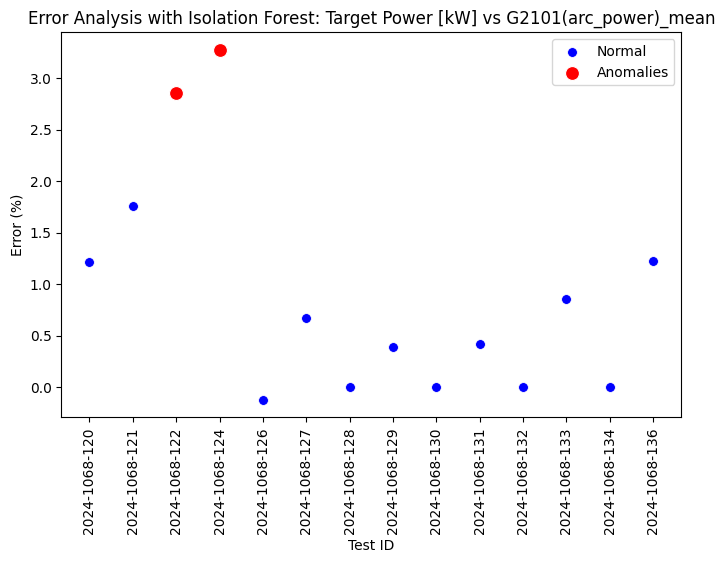

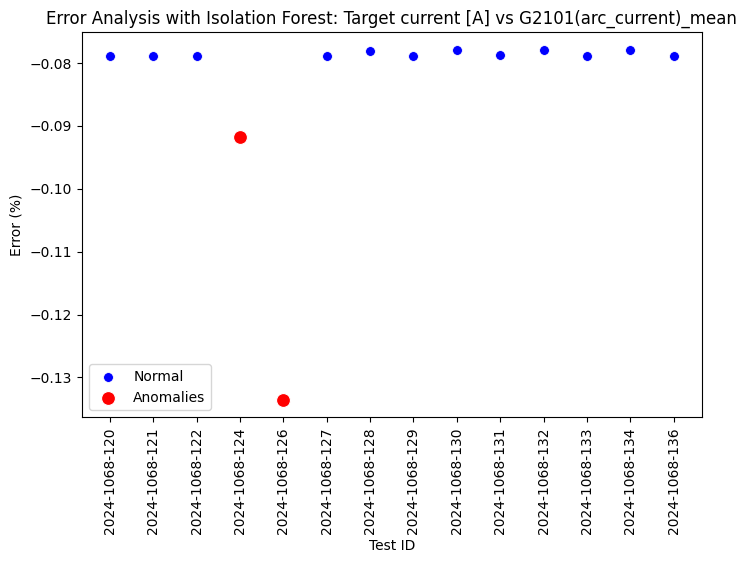

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pandas as pd

def Error_with_IsolationForest(final_df, target_col, actual_col):
    """
    Calculate Error percentage, plot results, and detect anomalies using Isolation Forest.
    
    Parameters:
        final_df: DataFrame containing the data.
        target_col: Column name for target values.
        actual_col: Column name for actual values.
    """
    # Calculate Error
    target = final_df[target_col]
    actual = final_df[actual_col]
    error = ((actual - target) / target) * 100
    
    # Add the error column to the DataFrame
    final_df['error'] = error
    
    # Drop NaNs (important for Isolation Forest to work)
    final_df.dropna(subset=['error'], inplace=True)
    
    # Initialize and fit the Isolation Forest model
    model = IsolationForest(contamination=0.1, random_state=42)
    final_df['anomaly'] = model.fit_predict(final_df[['error']])
    
    # Separate anomalies
    anomalies = final_df[final_df['anomaly'] == -1]
    
    # Plot Errors
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=final_df['Test_ID'], y=final_df['error'], label='Normal', color='blue', s=50)
    sns.scatterplot(x=anomalies['Test_ID'], y=anomalies['error'], label='Anomalies', color='red', s=100)
    plt.xlabel('Test ID')
    plt.ylabel('Error (%)')
    plt.title(f'Error Analysis with Isolation Forest: {target_col} vs {actual_col}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Example usage
Error_with_IsolationForest(final_df, 'Target Power [kW]', 'G2101(arc_power)_mean')
Error_with_IsolationForest(final_df, 'Target current [A]', 'G2101(arc_current)_mean')

## Timeseries

C:\Users\Admin Henry Chen\AppData\Local\Temp\ipykernel_46948\2152418585.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(test_ids))


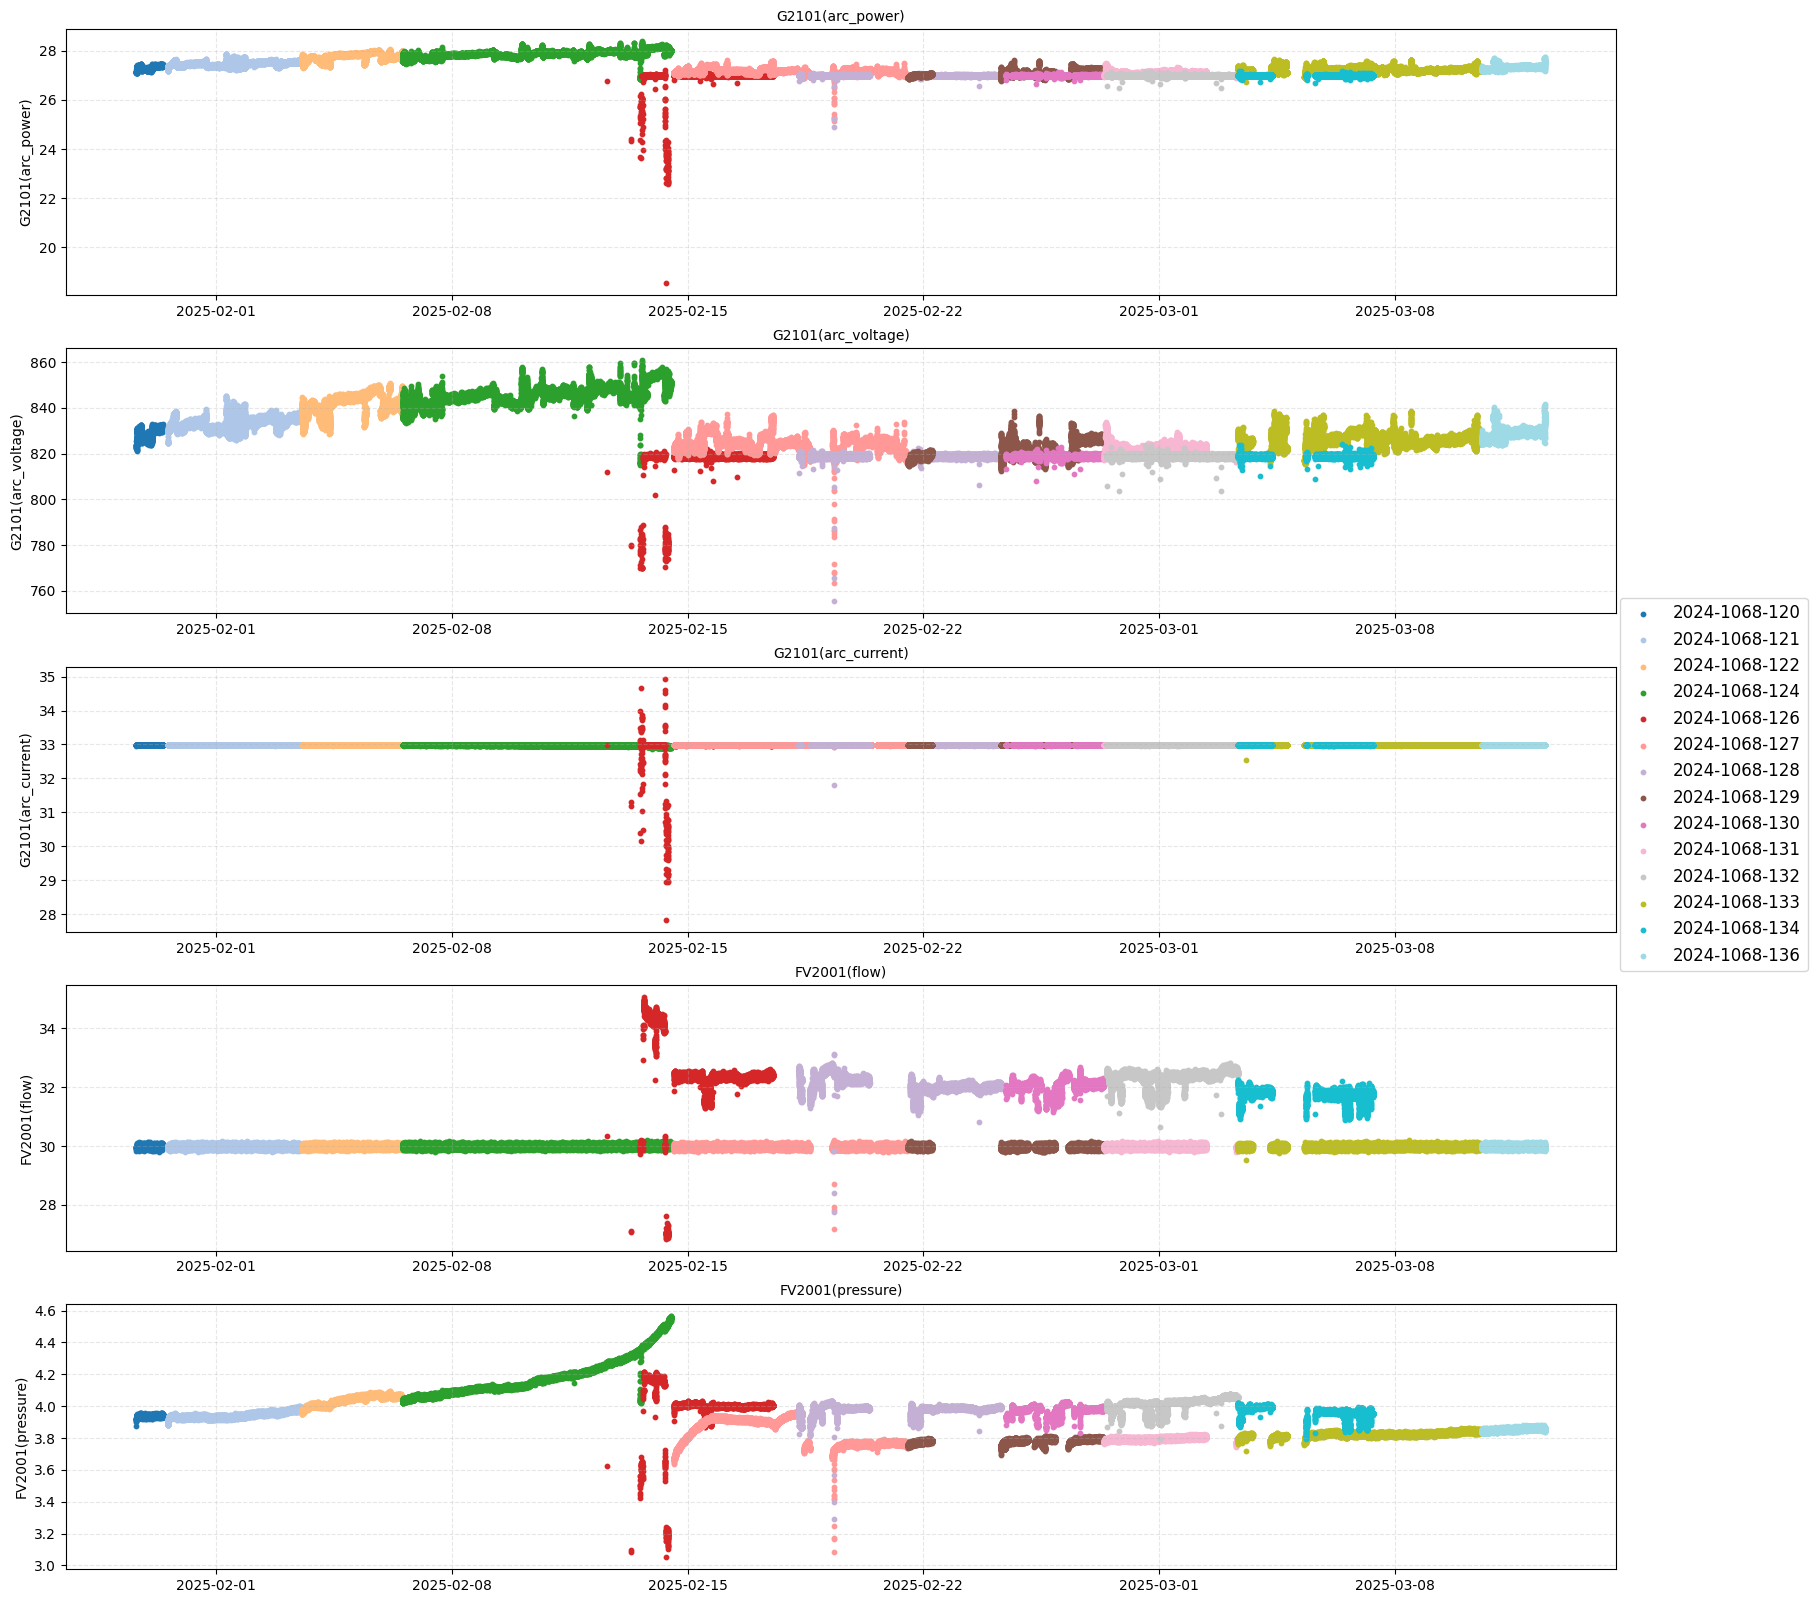

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get test IDs from metadata_df for DSE containing 'B52#'
test_ids = metadata_df.loc[metadata_df['DSE '].str.contains('B52', na=False), 'Test_ID'].to_list()

def plot_sensors_for_test_ids(test_ids, sensor_names):
    num_plots = len(sensor_names)
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, 4 * num_plots))
    axes = axes.flatten()

    # Generate a color map using unique colors for each test_id
    colors = plt.cm.get_cmap('tab20', len(test_ids))

    for i, test_id in enumerate(test_ids):
        stat_df = merged_dict[test_id]
        for j, sensor_name in enumerate(sensor_names):
            if sensor_name in stat_df.columns:
                # Use scatter plot instead of line plot
                axes[j].scatter(stat_df['timestamp'], stat_df[sensor_name], label=f'{test_id}', color=colors(i), s=10)
                axes[j].set_title(sensor_name, fontsize='medium')
                axes[j].set_ylabel(sensor_name, fontsize='medium')
                axes[j].grid(True, linestyle='--', alpha=0.3)

    # Add legend to the figure once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize='large', bbox_to_anchor=(1, 0.6))

# Plotting the sensors
plot_sensors_for_test_ids(test_ids, ['G2101(arc_power)', 'G2101(arc_voltage)', 'G2101(arc_current)', 'FV2001(flow)', 'FV2001(pressure)'])

In [13]:
# import matplotlib.pyplot as plt
# import pandas as pd

# def plot_sensors_for_test_ids_relative_time(test_ids, sensor_names):
#     fig, axes = None, None

#     for test_id in test_ids:
#         if test_id not in merged_dict:
#             print(f"Test ID {test_id} not found in the dataset.")
#             continue
        
#         df = merged_dict[test_id]
#         available_sensors = [name for name in sensor_names if name in df.columns]

#         if fig is None:
#             num_plots = len(available_sensors)
#             num_cols = 3
#             num_rows = (num_plots + num_cols - 1) // num_cols
#             fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
#             axes = axes.flatten()

#         # Calculate relative timestamps
#         start_time = pd.to_datetime(df['timestamp'].iloc[0])
#         relative_time = (pd.to_datetime(df['timestamp']) - start_time).dt.total_seconds()

#         for i, sensor_name in enumerate(available_sensors):
#             sensor_data = df[sensor_name]
#             axes[i].plot(relative_time, sensor_data, label=f'{test_id}')
#             # axes[i].plot(relative_time, sensor_data, label=f'{test_id} - {sensor_name}')

#             # axes[i].tick_params(axis='x', rotation=90, labelsize='small')
#             # axes[i].tick_params(axis='y', labelsize='small')
#             axes[i].set_title(sensor_name, fontsize='small')
#             # axes[i].set_xlabel('Relative Time (seconds)', fontsize='small')
#             # axes[i].set_ylabel(sensor_name, fontsize='small')
#             axes[i].legend(loc='upper left', fontsize='small', bbox_to_anchor=(0,-0.1))
#             # axes[i].grid(True, linestyle='--', alpha=0.3)

#     if fig is not None:
#         for j in range(len(available_sensors), len(axes)):
#             fig.delaxes(axes[j])

#         # plt.subplots_adjust(hspace=0.5, wspace=0.3)
#         # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         plt.show()

# # Example usage:
# plot_sensors_for_test_ids_relative_time(

#     ['2024-1068-124'],

#     ['G2101(arc_power)', 'G2101(arc_voltage)', 'G2101(arc_current)',
#     #  'Channel_2(NO_Corrected)', 'Channel_2(NO2_Corrected)','NOx%',
#     #  'FV2001(flow)', 'FV2011(flow)', 'FV2001(flow)+FV2011(flow)',
#     #  'O2%_calc','enthalpy_calc', 'EC_calc', 'TT2204(temperature)'
#      ]
# )

# EDA (Visual)

## CV

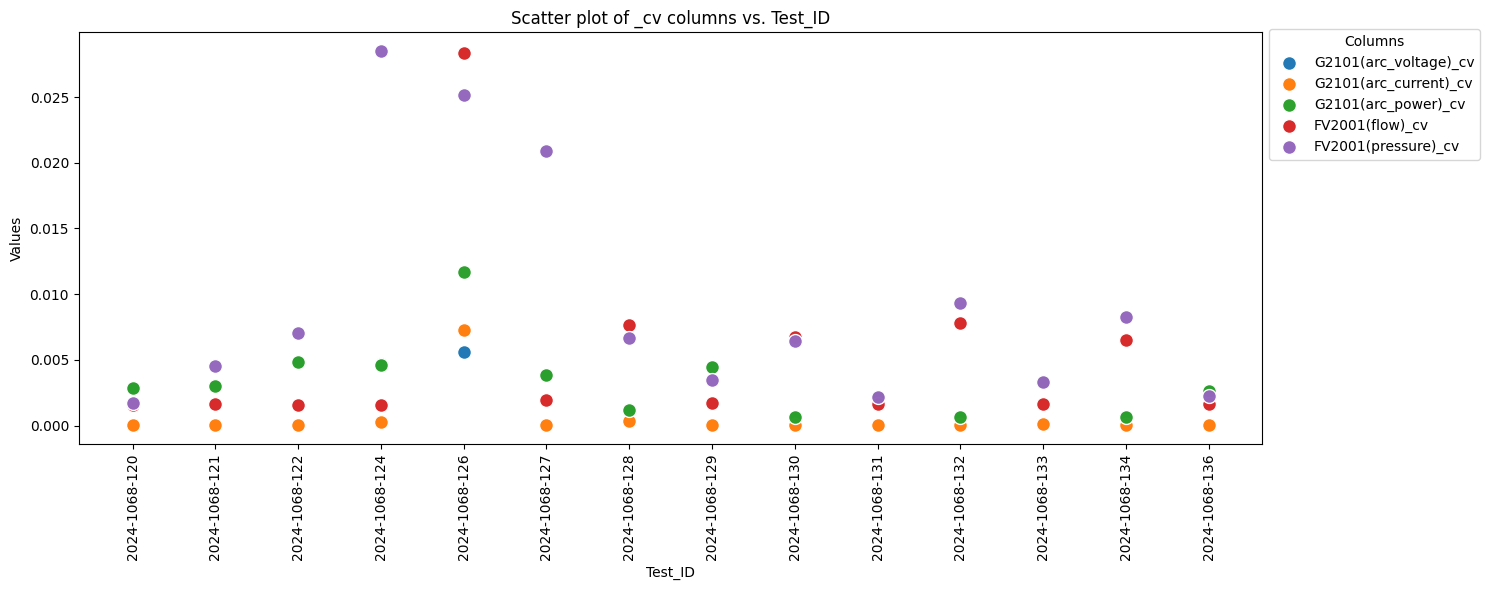

In [14]:
import pandas as pd

def plot_all_cv_columns_in_one(final_df):
    columns_cv = [
                'G2101(arc_voltage)_cv',
                'G2101(arc_current)_cv',
                'G2101(arc_power)_cv',
                'FV2001(flow)_cv',
                'FV2001(pressure)_cv',
                ]

    plt.figure(figsize=(15,6))
    for col in columns_cv:
        plt.scatter(final_df['Test_ID'], final_df[col], label=col, alpha=0.99, edgecolors='white', s=100, marker='o')
    plt.title("Scatter plot of _cv columns vs. Test_ID")
    plt.xlabel('Test_ID')
    plt.ylabel('Values')
    plt.xticks(rotation=90)  # Rotate Test_ID labels for better readability
    plt.legend(title='Columns', bbox_to_anchor=(1, 1.025), loc='upper left')  # Position the legend outside the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_all_cv_columns_in_one(final_df)

## Distance Correlation

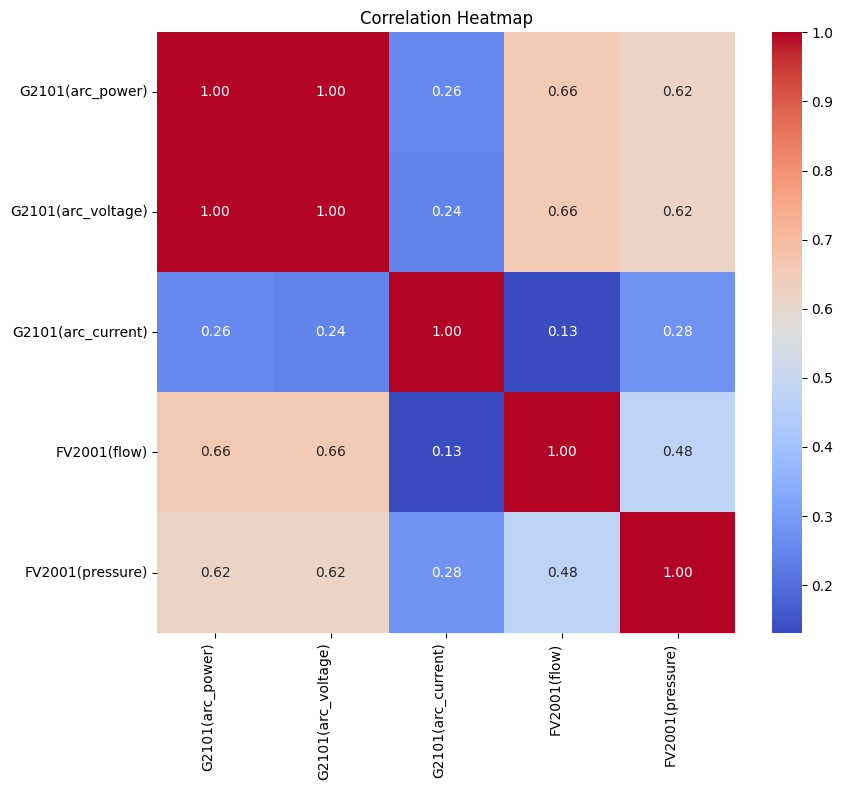

In [15]:
# Assuming final_df is your DataFrame and you've already selected the columns
selected_columns = [
    'G2101(arc_power)',
    'G2101(arc_voltage)',
    'G2101(arc_current)',
    'FV2001(flow)',
    'FV2001(pressure)',
]

interaction_df = merged_influx_df[selected_columns].copy()

# Initialize a DataFrame to store the distance correlations
dist_corr_df = pd.DataFrame(index=selected_columns, columns=selected_columns)

# Calculate pairwise distance correlations
for i, col1 in enumerate(selected_columns):
    for col2 in selected_columns[i:]:
        dist_corr_value = dcor.distance_correlation(interaction_df[col1], interaction_df[col2])
        dist_corr_df.loc[col1, col2] = dist_corr_value
        dist_corr_df.loc[col2, col1] = dist_corr_value

# Generate the heatmap using seaborn
plt.figure(figsize=(9, 8))
sns.heatmap(dist_corr_df.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

In [16]:
merged_influx_df.isna().sum()

timestamp              0
G2101(arc_voltage)     0
G2101(arc_power)       0
G2101(arc_current)     0
G2101(running)         0
G2101(temperature)     0
FV2001(flow)           0
FV2001(pressure)       0
FV2001(temperature)    0
system(running)        0
FT2301(flow)           0
FT2301(temperature)    0
TT2302(temperature)    0
TT2308(temperature)    0
FT2302(flow)           0
FT2302(temperature)    0
enthalpy_calc          0
dtype: int64

## Groupby

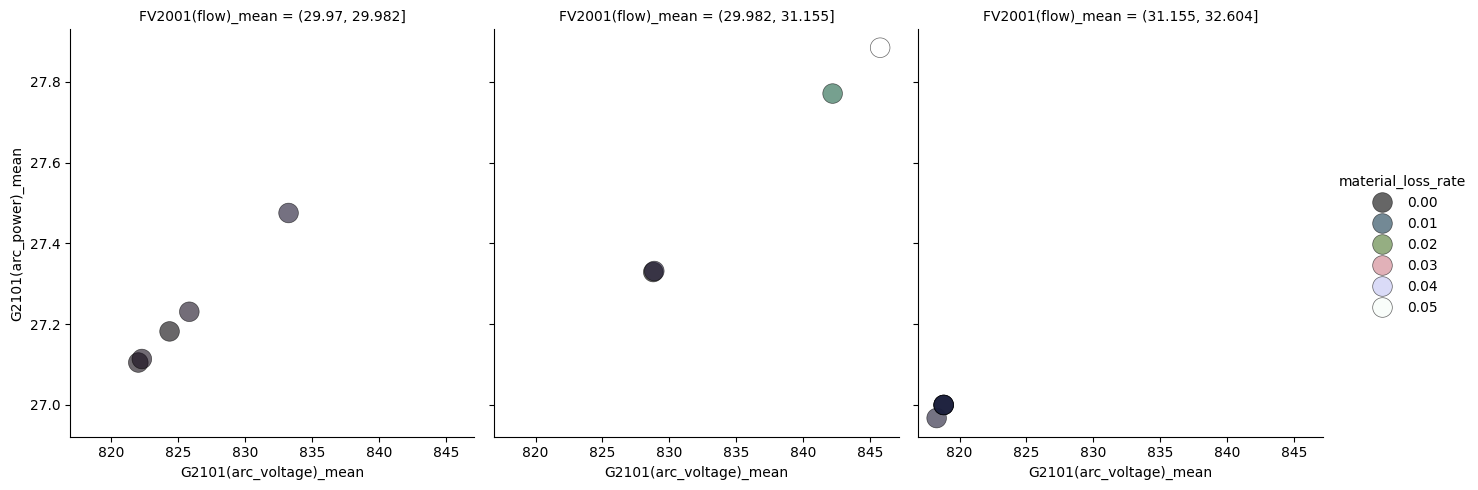

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the relplot with hue mapped to 'enthalpy_calc_mean'
g = sns.relplot(
    data=final_df,
    x='G2101(arc_voltage)_mean',
    y='G2101(arc_power)_mean',
    col=pd.qcut(final_df['FV2001(flow)_mean'], q=3),
    s=200,
    alpha=0.6,
    # size='material_loss_rate',
    # sizes=(100,800),
    # marker='o',
    edgecolor='black',
    linewidth=0.5,
    # color='gray',
    col_wrap=3,
    hue= 'material_loss_rate',
    palette='cubehelix',
    aspect=0.9
)
plt.show()

## mean and std

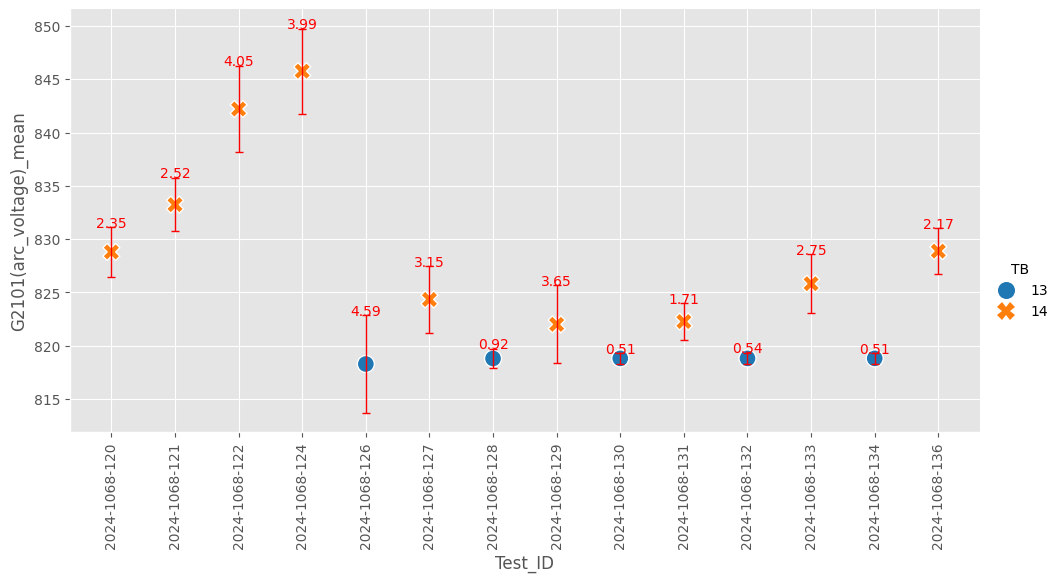

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

test_ids, means, stds = final_df['Test_ID'], final_df['G2101(arc_voltage)_mean'], final_df['G2101(arc_voltage)_std']

# Create a scatter plot with error bars
g = sns.relplot(x="Test_ID", y="G2101(arc_voltage)_mean", 
                hue="TB",
                palette='tab10',
                style='TB',
                markers=True, 
                kind="scatter", 
                data=final_df, 
                height=5, aspect=2, s=150
                )

# Add error bars
for idx, row in final_df.iterrows():

    plt.errorbar(row['Test_ID'], row['G2101(arc_voltage)_mean'],
                 yerr=row['G2101(arc_voltage)_std'], 
                 fmt='none', ecolor='red', elinewidth=1, capsize=3)
    
    plt.text(row['Test_ID'], row['G2101(arc_voltage)_mean'] + row['G2101(arc_voltage)_std'] + 0.001, 
             f'{row["G2101(arc_voltage)_std"]:.2f}', color='red', ha='center')

# Show the plot
plt.xticks(rotation=90)
# plt.legend(title='Group')
# plt.ylim(40,45)

plt.show()

# EDA (MachineLearning)

## IsolationForest

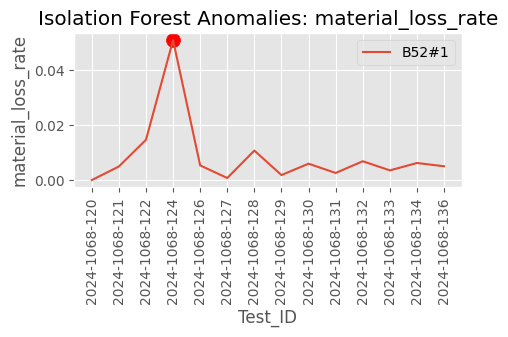

In [19]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Let the user pick the columns
columns_to_include = ['material_loss_rate']  # Replace with your desired columns

# Drop NaNs from selected columns and fill others with 0
final_df.dropna(subset=columns_to_include, inplace=True)
# final_df[columns_to_include] = final_df[columns_to_include].fillna(0)  # Replace NaNs with 0 (or use another method)

# Initialize and fit the Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=None)
final_df['anomaly'] = model.fit_predict(final_df[columns_to_include])

# Extract anomalies
anomalies = final_df[final_df['anomaly'] == -1]

# Plot the data and anomalies
for col in columns_to_include:
    plt.figure(figsize=(5, 2))
    plt.plot(final_df['Test_ID'], final_df[col], label=col)
    plt.scatter(anomalies['Test_ID'], anomalies[col], color='red', label='Anomaly', s=100)
    plt.title(f'Isolation Forest Anomalies: {col}')
    plt.legend(['B52#1'])
    plt.xlabel('Test_ID')
    plt.xticks(rotation=90)
    plt.ylabel(col)
    plt.show()

## XGBoost

G2101(arc_voltage)    0
G2101(arc_current)    0
G2101(arc_power)      0
FV2001(flow)          0
dtype: int64 0
G2101(arc_voltage)    0
G2101(arc_current)    0
G2101(arc_power)      0
FV2001(flow)          0
dtype: int64 0
r2_score: 0.9110


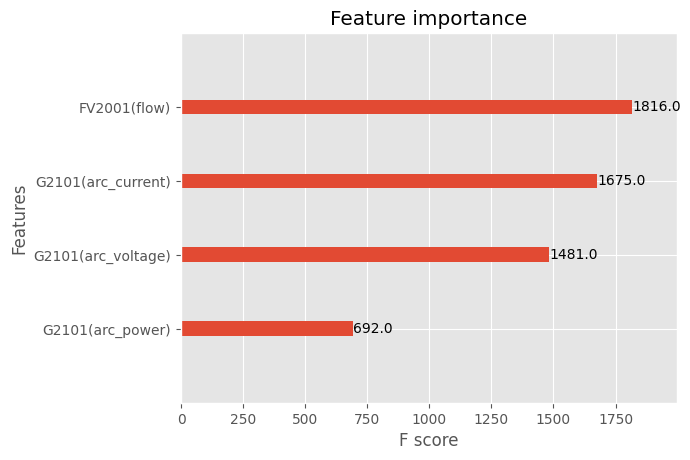

In [ ]:
merged_influx_df_XGBoost = merged_influx_df[['G2101(arc_voltage)',
'G2101(arc_current)',
'G2101(arc_power)',
'FV2001(flow)',
'FV2001(pressure)',
]]

# Define target and features
target = 'FV2001(pressure)'
X = merged_influx_df_XGBoost.drop(columns=[target])  # Independent variables
y = merged_influx_df_XGBoost[target]                 # Dependent variable

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for NaNs and Infs
print(X_train.isna().sum(), y_train.isna().sum())  # Missing values
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())  # Infinite values

# Drop or Fill missing values
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ensure matching indices
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     max_depth=5,          # Control tree depth (higher = more complex)
#     learning_rate=0.1,    # Step size (lower = better accuracy, slower training)
#     n_estimators=100,     # Number of trees (higher = better accuracy, slower training)
#     colsample_bytree=0.8, # Use 80% of features per tree (helps with collinearity)
#     random_state=42
# )
# model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
r2_score = r2_score(y_test, y_pred)
print(f"r2_score: {r2_score:.4f}")
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model, importance_type='weight')
plt.show()
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for feature impact
shap.summary_plot(shap_values, X_test)

## PCA

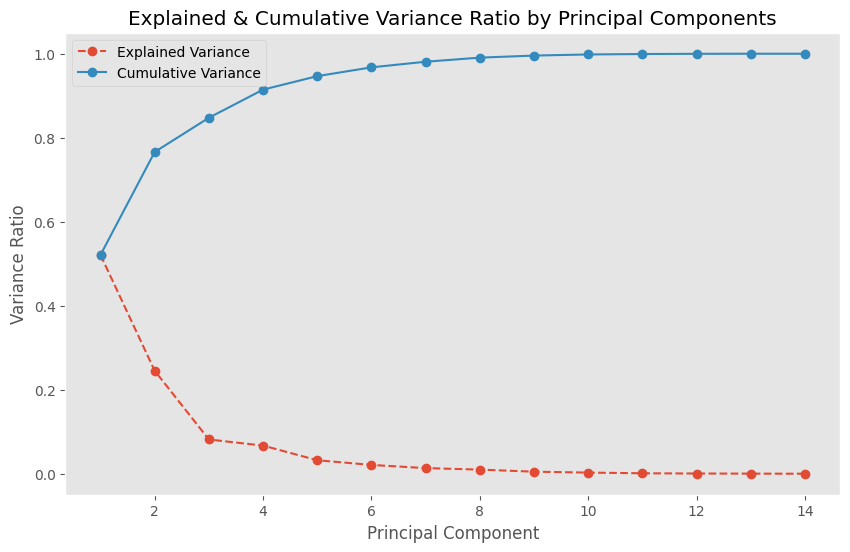

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.985946 -1.320328 -1.580313  2.053813  0.378926 -0.762752 -0.776964   
1 -2.841382 -0.327501 -0.941024  1.217343  0.506974  0.808463  0.946740   
2 -2.925894  1.085012 -0.676263  2.089101  0.763676  0.742349  0.086377   
3 -4.113455  7.933140  0.056601 -1.021868 -0.267900 -0.324658 -0.228631   
4  5.352259  0.124801 -3.260361 -1.140272 -1.289464  1.028858 -0.440549   

        PC8       PC9      PC10      PC11      PC12      PC13          PC14  
0 -0.275933 -0.343546  0.201734  0.236158 -0.138942  0.000577 -1.780961e-16  
1 -0.434088 -0.086132  0.200503 -0.177007  0.030963  0.150047 -1.780961e-16  
2  0.885495  0.346079 -0.251900 -0.040766  0.023038 -0.111724 -1.780961e-16  
3 -0.287503 -0.039086  0.001934  0.007977  0.001156  0.004393 -1.780961e-16  
4  0.139572 -0.002470  0.046908 -0.020434  0.000979 -0.002314 -1.780961e-16  


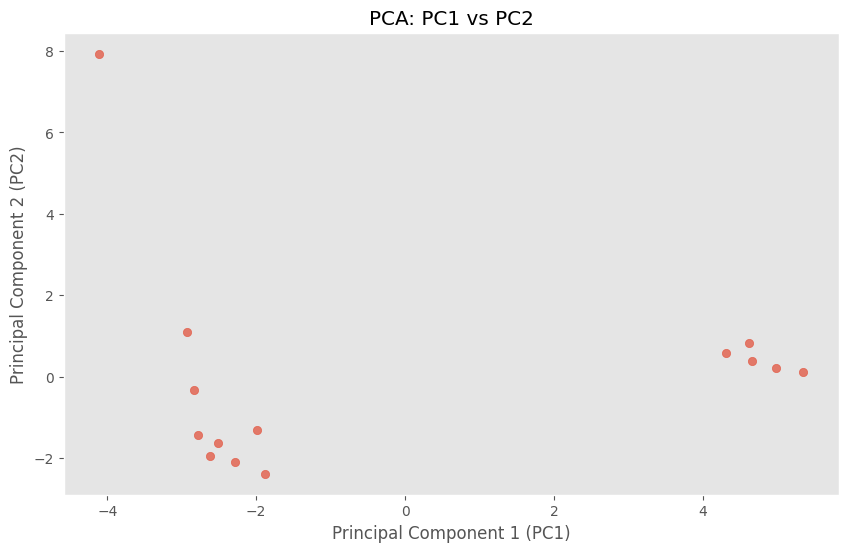

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clean DataFrame for PCA
columns_to_exclude = [col for col in final_df.columns if 'cv' in col or 'std' in col]
df_cleaned = final_df.drop(columns=columns_to_exclude + ['error'], errors='ignore').dropna(axis=1)
# Select numeric columns and drop NaN rows
df_numeric = df_cleaned.select_dtypes(include=[float, int]).dropna()

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame for principal components
pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained and cumulative variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o--', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'o-', label='Cumulative Variance')
plt.title('Explained & Cumulative Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid()
plt.show()

# Print first few rows of principal components
print(pca_df.head())

# Scatter plot of PC1 vs PC2
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
plt.title('PCA: PC1 vs PC2')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid()
plt.show()


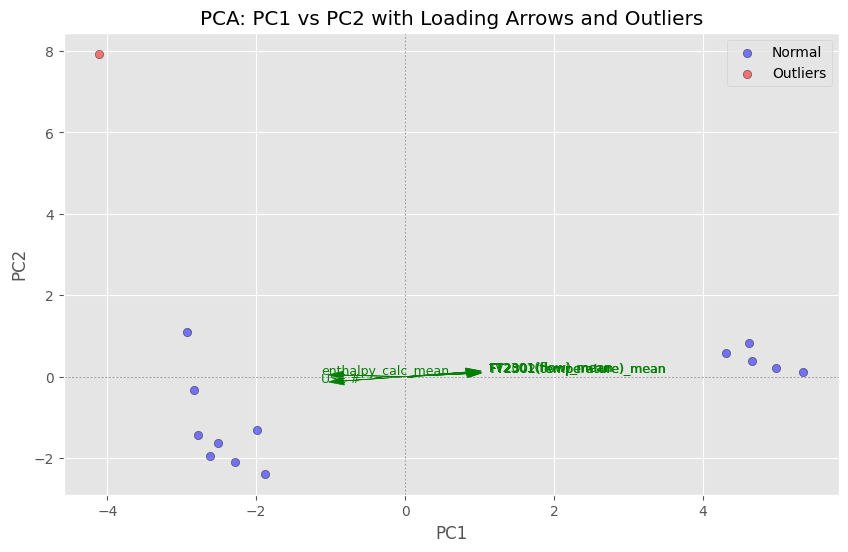

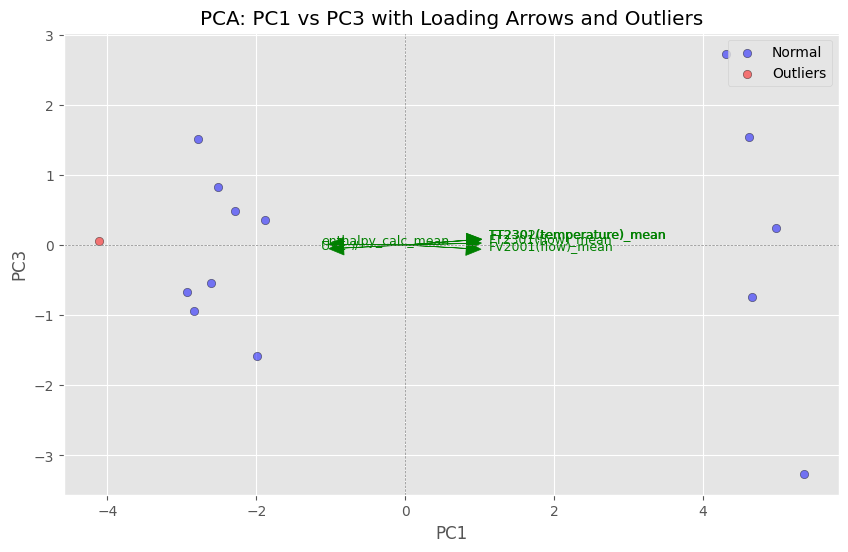

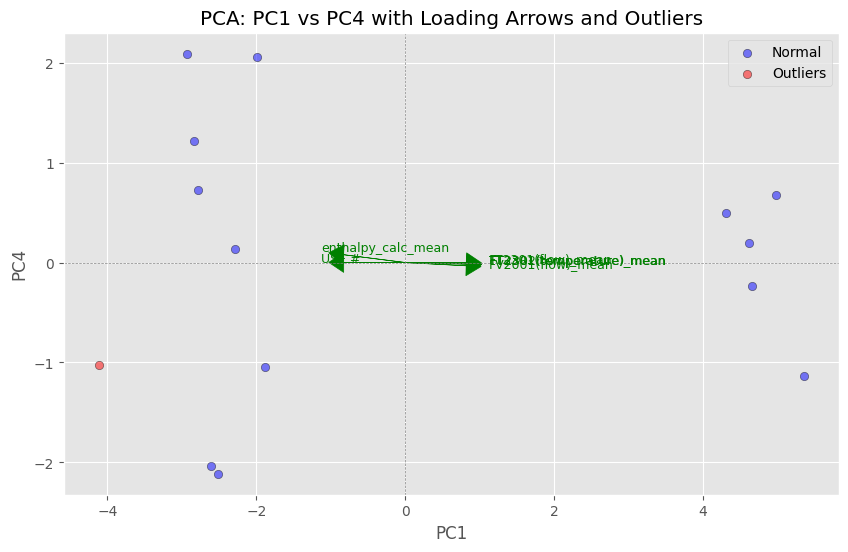

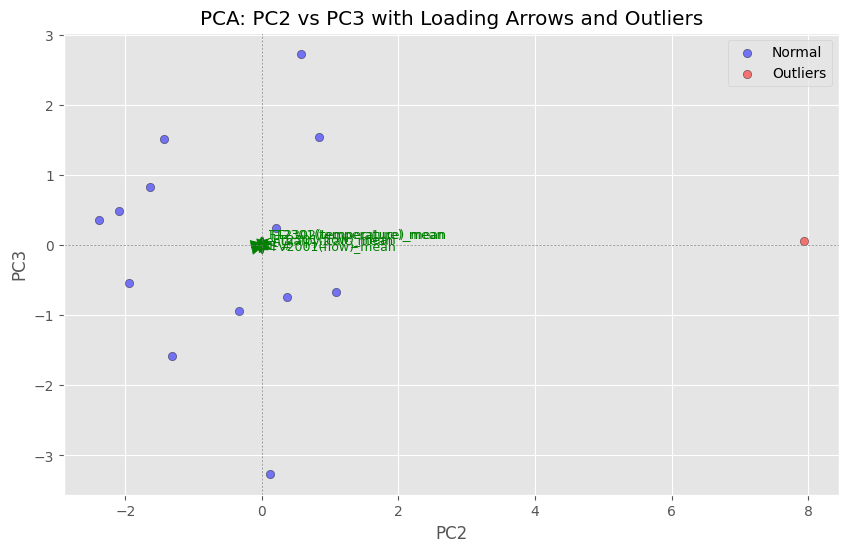

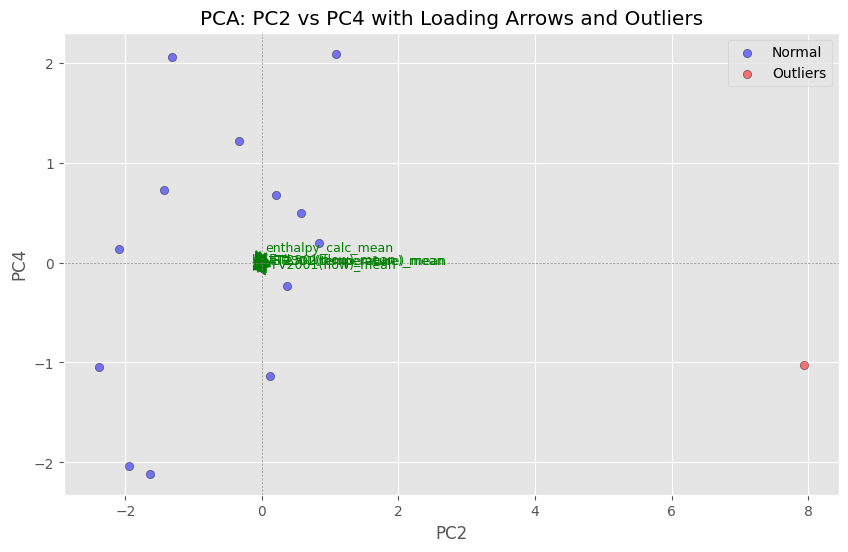

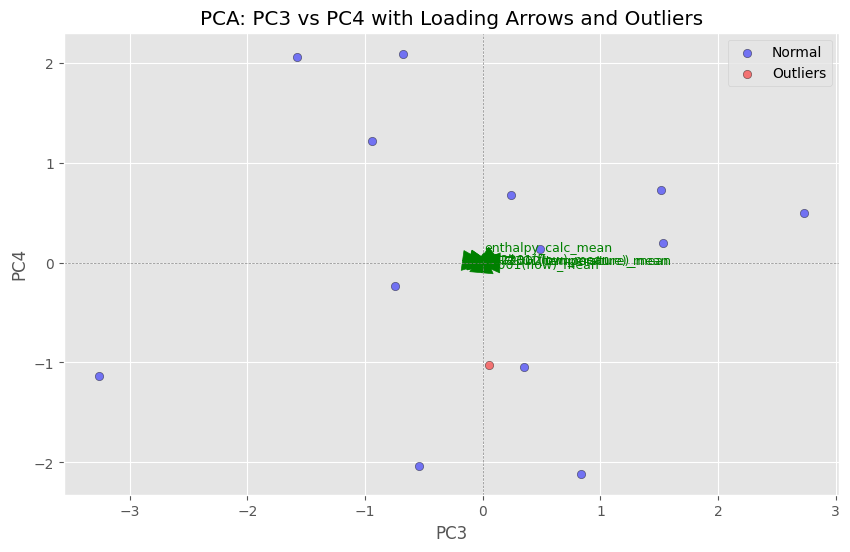

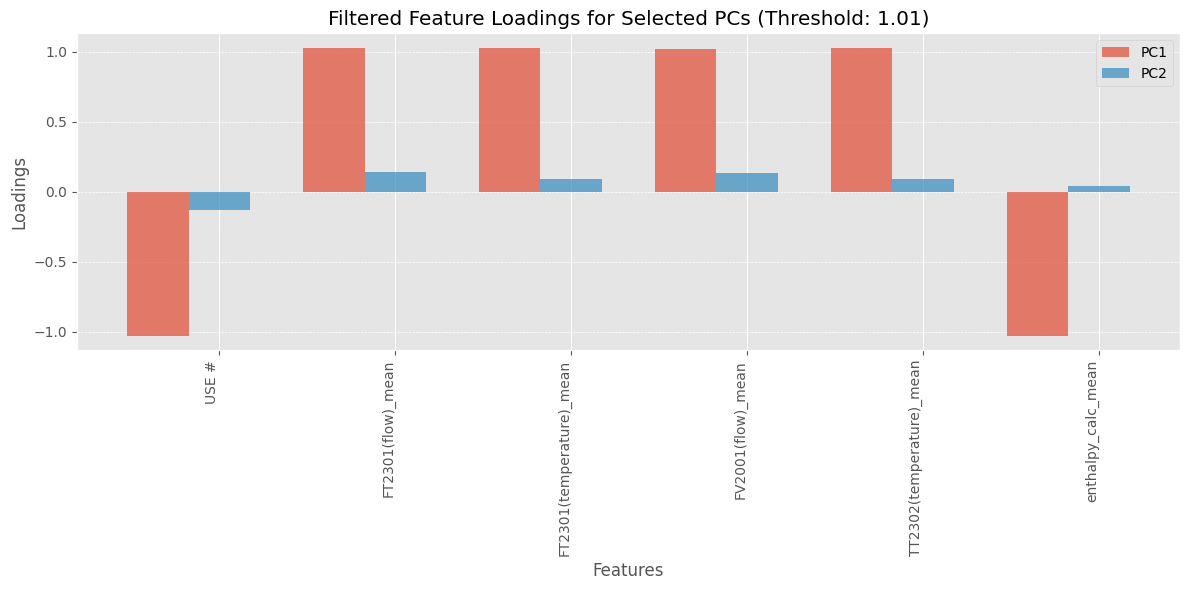

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Load and preprocess the DataFrame
# df_numeric = df_for_pca.select_dtypes(include=[float, int]).dropna()

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Perform PCA
n_components = 4
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
pca_df['Outlier'] = iso_forest.fit_predict(pca_df) == -1

# Compute and filter loadings based on a threshold
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
threshold = 1.01
filtered_indices = [i for i in range(loadings.shape[0]) if any(abs(loadings[i, j]) > threshold for j in range(n_components))]
filtered_loadings = loadings[filtered_indices]
filtered_features = [df_numeric.columns[i] for i in filtered_indices]

# Generate scatter plots for all PC pairs with loading arrows
for pc_x, pc_y in itertools.combinations(range(n_components), 2):
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_df[~pca_df['Outlier']][f'PC{pc_x+1}'], pca_df[~pca_df['Outlier']][f'PC{pc_y+1}'], 
                color='b', label='Normal', edgecolor='black', alpha=0.5)
    plt.scatter(pca_df[pca_df['Outlier']][f'PC{pc_x+1}'], pca_df[pca_df['Outlier']][f'PC{pc_y+1}'], 
                color='r', label='Outliers', edgecolor='black', alpha=0.5)
    
    # Add loading arrows
    for i, feature in enumerate(filtered_features):
        plt.arrow(0, 0, filtered_loadings[i, pc_x], filtered_loadings[i, pc_y], color='green', 
                  head_width=0.2, head_length=0.2, length_includes_head=True)
        plt.text(filtered_loadings[i, pc_x] * 1.1, filtered_loadings[i, pc_y] * 1.1, feature, color='green', fontsize=9)
    
    plt.title(f'PCA: PC{pc_x+1} vs PC{pc_y+1} with Loading Arrows and Outliers')
    plt.xlabel(f'PC{pc_x+1}')
    plt.ylabel(f'PC{pc_y+1}')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.show()

# Specify the PCs to plot (e.g., PC1 and PC2)
selected_pcs = [0, 1]  # Indices for PC1 and PC2

# Create a bar plot for the selected principal component loadings
plt.figure(figsize=(12, 6))
bar_width = 0.35
x_indices = np.arange(len(filtered_features))

for pc_idx in selected_pcs:
    plt.bar(x_indices + (pc_idx - len(selected_pcs) / 2) * bar_width, 
            filtered_loadings[:, pc_idx], bar_width, label=f'PC{pc_idx+1}', alpha=0.7)

plt.xticks(x_indices, filtered_features, rotation=90, ha='right')
plt.title(f'Filtered Feature Loadings for Selected PCs (Threshold: {threshold})')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Outlier

Cluster

In [ ]:
# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # Load the DataFrame
# df = pd.read_pickle('merged_influx_df.pkl')

# # Drop non-numeric columns
# df_numeric = df.select_dtypes(include=[float, int])

# # Drop rows with NaN values
# df_numeric = df_numeric.dropna()

# # Standardize the data
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_numeric)

# # Perform PCA
# pca = PCA(n_components=2)  # Use only the first two principal components
# principal_components = pca.fit_transform(df_scaled)
# pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

# # Apply k-Means Clustering
# num_clusters = 4 # You can choose the number of clusters
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# kmeans.fit(pca_df)
# pca_df['Cluster'] = kmeans.labels_

# # Plot PC1 vs PC2 and color points by cluster
# plt.figure(figsize=(10, 6))
# for cluster in range(num_clusters):
#     cluster_data = pca_df[pca_df['Cluster'] == cluster]
#     plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')
    
# plt.title('PCA: PC1 vs PC2 with Clusters')
# plt.xlabel('Principal Component 1 (PC1)')
# plt.ylabel('Principal Component 2 (PC2)')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()

# # Print first few rows of the DataFrame with cluster labels
# print(pca_df.head())


In [ ]:
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf

# # List the columns to include
# columns_to_include = ['G2101(arc_voltage)']

# # Loop through each DataFrame in the dictionary
# for key, merged_influx_df in merged_dict.items():
#     for col in columns_to_include:
#         # Ensure the timestamp column is in datetime format
#         merged_influx_df['timestamp'] = pd.to_datetime(merged_influx_df['timestamp'])
        
#         plt.figure(figsize=(5, 2))
#         plot_acf(merged_influx_df.set_index('timestamp')[col].dropna(), lags=100, title=f'ACF for {col} in {key}')
        
#         # Add axis labels
#         plt.xlabel('Lags')
#         plt.ylabel('Autocorrelation')
        
#         plt.show()